In [1]:
from IPython.display import display, SVG
from typing import Optional, Sequence
import dataclasses
import math
import enum

from typesetting import ParagraphItem, ParagraphItemType, Font, Glyph, hyphenate, text_to_paragraph_items, MAX_PENALTY, paragraph_item_running_sums, greedy_line_breaks
from typesetting.cairo import fill_glyphs_at

Source:

http://www.eprg.org/G53DOC/pdfs/knuth-plass-breaking.pdf

In [2]:
from faker import Faker
import textwrap

Faker.seed(0x01234567)
lorem = hyphenate("".join([
    "Difficult Quick Foxes with 1034 boxes. ",
    Faker(["en"]).paragraph(20)
]))
print(f"Generated lorem ipsum:\n\n{textwrap.fill(textwrap.shorten(lorem, 200), 72)}")
print(f"\nRepr of first part:\n{textwrap.shorten(lorem, 72)!r}")

Generated lorem ipsum:

Dif­fi­cult Quick Foxes with 1034 boxes. Ques­tion drug can­di­date.
Edge I mes­sage here. Ex­pert cold sci­en­tist can­di­date black brother
him. Worry per­haps talk pull blue let­ter. Gun [...]

Repr of first part:
'Dif\xadfi\xadcult Quick Foxes with 1034 boxes. Ques\xadtion drug [...]'


In [3]:
rm_face_path = "EBGaramond-VariableFont_wght.ttf"
rm_size = 14
rm_font = Font(path=rm_face_path, em_size=[rm_size, rm_size], features=["onum"])

sm_rm_size = rm_size * 0.8
sm_rm_font = Font(path=rm_face_path, em_size=[sm_rm_size, sm_rm_size], features=["onum"])

In [4]:
import uniseg.linebreak
print(textwrap.fill("|".join(uniseg.linebreak.line_break_units(lorem)), 80))

Dif­|fi­|cult |Quick |Foxes |with |1034 |boxes. |Ques­|tion |drug
|can­|di­|date. |Edge |I |mes­|sage |here. |Ex­|pert |cold |sci­|en­|tist
|can­|di­|date |black |brother |him. |Worry |per­|haps |talk |pull |blue
|let­|ter. |Gun |choose |abil­|ity |fin­|ish. |Cut |decade |hun­|dred |whom
|short |past. |I |win |num­|ber |ta­|ble |party. |In­|di­|vid­|ual |laugh |end
|af­|fect |present |imag­|ine |body. |Hear |es­|tab­|lish |pay |go
|pol­|i­|tics. |Cell |re­|veal |sit |try |mem­|ory |own |op­|er­|a­|tion
|ma­|jor­|ity. |Player |old |ap­|ply |lan­|guage |hus­|band |ei­|ther. |Lawyer
|com­|mon |artist |space.


In [5]:
para_items = list(text_to_paragraph_items(lorem, rm_font))

if False:
    print("First few items:")
    print("\n".join(textwrap.indent(f"{item!r}", "  ") for item in para_items[:10]))
    print("Final few items:")
    print("\n".join(textwrap.indent(f"{item!r}", "  ") for item in para_items[-10:]))

In [6]:
import io
from IPython.display import display, SVG
import cairo
from typing import Iterable

def render_lines(ctx: cairo.Context, line_break_idxs: Iterable[int], x0: float, y0: float, line_width: float):
    line_start_idx = 0
    for line_idx, line_end_idx in enumerate(line_break_idxs):
        x = x0
        y = line_height*line_idx + y0
        running_text, running_width = [], 0.0
    
        # What delta needs to be taken up by glue
        natural_width, total_stretch, total_shrink = 0.0, 0.0, 0.0
        for item in para_items[line_start_idx:line_end_idx]:
            if item.item_type == ParagraphItemType.PENALTY:
                continue
            natural_width += item.width
            if item.item_type == ParagraphItemType.GLUE:
                total_stretch += item.stretchability
                total_shrink += item.shrinkability
        if para_items[line_end_idx].item_type == ParagraphItemType.PENALTY:
            natural_width += para_items[line_end_idx].width
        delta = line_width - natural_width
    
        # Total slack for delta
        if delta > 0.0:
            adjustment_ratio = delta / total_stretch if total_stretch > 0 else math.inf
        elif delta < 0.0:
            adjustment_ratio = delta / total_shrink if total_shrink > 0 else math.inf
        else:
            adjustment_ratio = 0.0

        fill_glyphs_at(ctx, x + line_width + rm_font.em_size[0], y, sm_rm_font.shape(f"{adjustment_ratio:.2f}"), sm_rm_font)

        # adjustment_ratio = 0.0
        for item_idx in range(line_start_idx, line_end_idx+1):
            item = para_items[item_idx]
            if item_idx != line_end_idx and item.item_type == ParagraphItemType.PENALTY:
                continue
            if item_idx == line_end_idx and item.item_type == ParagraphItemType.GLUE:
                continue
            running_width += item.width
            if item.item_type == ParagraphItemType.GLUE:
                text = "".join(running_text)
                fill_glyphs_at(ctx, x, y, rm_font.shape(text), rm_font)
                x += running_width
                if adjustment_ratio > 0:
                    x += item.stretchability * adjustment_ratio
                else:
                    x += item.shrinkability * adjustment_ratio
    
                running_text, running_width = [], 0.0
            else:
                running_text.append(item.text)
        text = "".join(running_text)
        if text != "":
            fill_glyphs_at(ctx, x, y, rm_font.shape(text), rm_font)
        line_start_idx = line_end_idx+1

In [7]:
from typing import Optional

class FitnessClass(enum.IntEnum):
    TIGHT = 0
    NORMAL = 1
    LOOSE = 2
    VERY_LOOSE = 3

@dataclasses.dataclass(frozen=True, eq=True)
class Node:
    # index of para item just at end of line
    position: int

    # number of the line ending at this breakpoint
    line_idx: int

    # fitness class of the line at this breakpoint
    fitness_class: FitnessClass

    # running sums
    total_width: float
    total_stretch: float
    total_shrink: float
    total_demerits: float

    previous: Optional["Node"] = None

In [8]:
line_width = 4 * 72

In [17]:
import math
from sortedcontainers import SortedSet, SortedDict

NodeKey = tuple[int, int, FitnessClass]
def make_node_key(n: Node) -> NodeKey:
    return (n.line_idx, n.position, n.fitness_class)

active_nodes = SortedDict[NodeKey, Node]()
all_nodes: dict[NodeKey, set[Node]] = {}

def activate_node_if_better(node: Node):
    key = make_node_key(node)
    existing_active = active_nodes.get(key)
    if existing_active is None or existing_active.total_demerits > b.total_demerits:
        active_nodes[key] = node
    try:
        all_nodes[key].add(node)
    except KeyError:
        all_nodes[key] = {node}

def deactivate_node(node: Node):
    del active_nodes[make_node_key(node)]

# Create active node representing beginning of paragraph
start_node = Node(
    position=-1, line_idx=0, fitness_class=FitnessClass.NORMAL,
    total_width=0.0, total_stretch=0.0, total_shrink=0.0,
    total_demerits=0.0
)
activate_node_if_better(start_node)

upper_adjustment_ratio = 2.0
looseness = 0.0
extra_flag_penalty = 50
line_penalty = 10
mismatched_fitness_penalty = 50

sum_width, sum_stretch, sum_shrink = 0.0, 0.0, 0.0
prev_was_box = False
most_recent_deactivated_node: Optional[Node] = None
for end_idx in range(len(para_items)):
    item = para_items[end_idx]
    is_feasible_breakpoint = False
    
    if item.item_type == ParagraphItemType.GLUE:
        is_feasible_breakpoint = prev_was_box
    elif item.item_type == ParagraphItemType.PENALTY:
        is_feasible_breakpoint = item.penalty < MAX_PENALTY
    
    if is_feasible_breakpoint:
        feasible_breaks: set[Node] = set()
        for node in list(active_nodes.values()):
            natural_width = sum_width - node.total_width
            if item.item_type == ParagraphItemType.PENALTY:
                natural_width += item.width

            if natural_width < line_width:
                line_stretch = sum_stretch - node.total_stretch
                adjustment_ratio = (line_width - natural_width)/line_stretch if line_stretch > 0 else math.inf
            elif natural_width > line_width:
                line_shrink = sum_shrink - node.total_shrink
                adjustment_ratio = (line_width - natural_width)/line_shrink if line_shrink > 0 else math.inf
            else:
                adjustment_ratio = 0.0

            if adjustment_ratio < -1.0 or item.penalty <= -MAX_PENALTY:
                deactivate_node(node)

            if adjustment_ratio >= -1.0 and adjustment_ratio < upper_adjustment_ratio:
                penalty = item.penalty
                
                prev_item: Optional[ParagraphItem] = para_items[node.position] if node.position >= 0 else None
                if prev_item is not None:
                    if item.flagged and prev_item.flagged:
                        penalty += extra_flag_penalty

                if adjustment_ratio < -0.5:
                    fitness_class = FitnessClass.TIGHT
                elif adjustment_ratio < 0.5:
                    fitness_class = FitnessClass.NORMAL
                elif adjustment_ratio < 1.0:
                    fitness_class = FitnessClass.LOOSE
                else:
                    fitness_class = FitnessClass.VERY_LOOSE

                if abs(node.fitness_class - fitness_class) > 1:
                    penalty += mismatched_fitness_penalty

                penalty += line_penalty

                if penalty >= 0.0:
                    demerit = (1.0 + 100.0 * (abs(adjustment_ratio) ** 3.0) + penalty) ** 2.0
                elif penalty > -MAX_PENALTY:
                    demerit = (1.0 + 100.0 * (abs(adjustment_ratio) ** 3.0)) ** 2.0 - (penalty ** 2.0)
                else:
                    demerit = (1.0 + 100.0 * (abs(adjustment_ratio) ** 3.0)) ** 2.0
                
                total_demerits = demerit + node.total_demerits
                total_width = sum_width
                total_stretch, total_shrink = sum_stretch, sum_shrink
                if item.item_type == ParagraphItemType.GLUE:
                    total_stretch += item.stretchability
                    total_shrink += item.shrinkability
                if item.item_type != ParagraphItemType.PENALTY:
                    total_width += item.width
                    
                break_node = Node(
                    position=end_idx,
                    line_idx=node.line_idx + 1,
                    fitness_class=fitness_class,
                    total_width=total_width,
                    total_stretch=total_stretch, total_shrink=total_shrink,
                    total_demerits=total_demerits, previous=node
                )
                feasible_breaks.add(break_node)

        for b in feasible_breaks:
            activate_node_if_better(b)
        
    if item.item_type != ParagraphItemType.PENALTY:
        sum_width += item.width
    if item.item_type == ParagraphItemType.GLUE:
        sum_stretch += item.stretchability
        sum_shrink += item.shrinkability
        
    prev_was_box = item.item_type == ParagraphItemType.BOX

print(f"Remaining active node count: {len(active_nodes)}")
nodes = list(active_nodes.values())
nodes.sort(key=lambda n: n.total_demerits)
node = nodes[0]

print(f"Optimal demerit {node.total_demerits:.0f}")
best_path_nodes: set[Node] = set()
optimal_line_break_idxs = []
while node is not None:
    best_path_nodes.add(node)
    if node.position >= 0:
        optimal_line_break_idxs.append(node.position)
    node = node.previous
optimal_line_break_idxs = list(reversed(optimal_line_break_idxs))

Remaining active node count: 1
Optimal demerit -871562


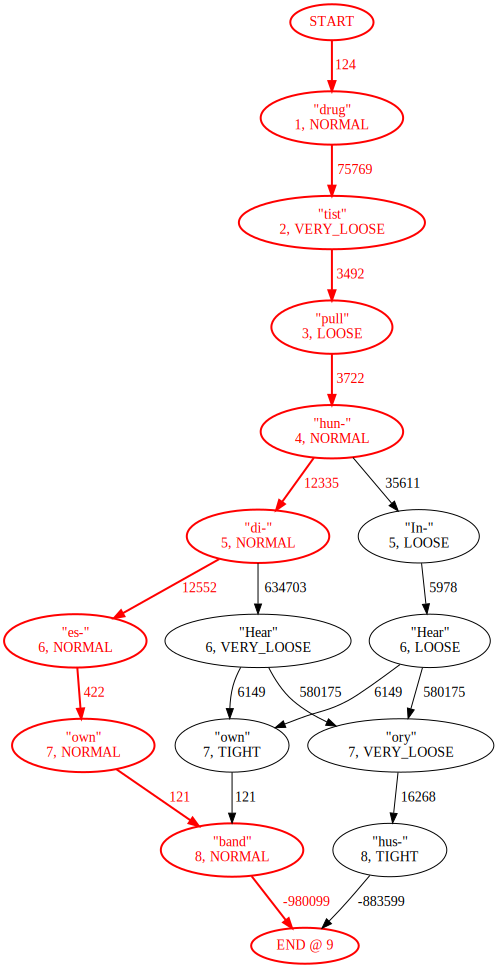

In [18]:
from graphviz import Digraph
dot = Digraph()
node_names: dict[NodeKey, str] = {}

for node_key, nodes in all_nodes.items():
    for n in nodes:
        if n.position == len(para_items) - 1:
            label = f"END @ {n.line_idx}"
        elif n.position == -1:
            label = "START"
        else:
            label = f"\"{''.join(item.text for item in para_items[n.position - 1:n.position + 1]).rstrip()}\"\n{n.line_idx}, {n.fitness_class.name}"
        node_attrs = {}
        if n in best_path_nodes:
            node_attrs["color"] = "red"
            node_attrs["fontcolor"] = "red"
            node_attrs["penwidth"] = "2"
        node_names[node_key] = node_names.get(node_key, f"{len(node_names)}")
        dot.node(node_names[node_key], label, **node_attrs)
        
for node_key, nodes in all_nodes.items():
    for n in nodes:
        if n.previous is None:
            continue
        demerit_delta = n.total_demerits - n.previous.total_demerits
        edge_attrs = {}
        if n in best_path_nodes and n.previous in best_path_nodes:
            edge_attrs["color"] = "red"
            edge_attrs["fontcolor"] = "red"
            edge_attrs["penwidth"] = "2"
        dot.edge(node_names[make_node_key(n.previous)], node_names[node_key], f"{demerit_delta:.0f}", **edge_attrs)
dot

In [19]:
greedy_line_break_idxs = list(greedy_line_breaks(para_items, line_width))
line_height = rm_size * 1.1
paper_size = (2 * (line_width + rm_font.em_size[0] * 4), line_height * (max(len(greedy_line_break_idxs), len(optimal_line_break_idxs)) + 2))

In [20]:
def draw_page(ctx: cairo.Context, line_break_idxs: Sequence[int], line_width: float, line_height: float):
    ctx.set_source_rgba(1, 0, 0, 0.5)
    ctx.set_line_width(1.0)

    ctx.move_to(rm_size, 0)
    ctx.rel_line_to(0, paper_size[1])
    ctx.move_to(rm_size + line_width, 0)
    ctx.rel_line_to(0, paper_size[1])
    ctx.close_path()
    ctx.stroke()
    
    ctx.set_source_rgb(0, 0, 0)
    render_lines(ctx, line_break_idxs, rm_size, 2*line_height, line_width)

svg_file = io.BytesIO()
with cairo.SVGSurface(svg_file, paper_size[0], paper_size[1]) as surface:
    ctx = cairo.Context(surface)
    ctx.set_source_rgb(1, 1, 1)
    ctx.rectangle(0, 0, paper_size[0], paper_size[1])
    ctx.fill()

    draw_page(ctx, greedy_line_break_idxs, line_width, line_height)
    ctx.translate(line_width + rm_font.em_size[0] * 4, 0)
    draw_page(ctx, optimal_line_break_idxs, line_width, line_height)
display(SVG(svg_file.getvalue()))

with cairo.PDFSurface("example.pdf", paper_size[0], paper_size[1]) as surface:
    ctx = cairo.Context(surface)
    ctx.set_source_rgb(1, 1, 1)
    ctx.rectangle(0, 0, paper_size[0], paper_size[1])
    ctx.fill()

    draw_page(ctx, greedy_line_break_idxs, line_width, line_height)
    ctx.translate(line_width + rm_font.em_size[0] * 4, 0)
    draw_page(ctx, optimal_line_break_idxs, line_width, line_height)